## Introduction

This in-class example demonstrates how to calculate heteroskeasticity-robust standard error and conduct tests on the existence of heteroskedasticity.

What you need to know:  
- Statsmodels and pandas modules in Python
- Theoretical concepts on time series regression model

The list of [references](#References) for detailed concepts and techniques used in this exerise.

***
## Data Description

The data set is contained in a comma-separated value (csv) file named ```HSEINV.csv``` with column headers. 

The data is a set of annual observations on housing investment and a housing price index in the United States for 1947 through 1988.

Description of the data is as follow:

| Name | Description |
| :--- | :--- |
| Name | Description |
| year | 1947-1988 |
| inv | real housing inv, millions \$ |
| pop | population, 1000s |
| price | housing price index; 1982 = 1 |
| invpc | per capita inv: inv/pop |
| linv | log(inv) |
| lpop | log(pop) |
| lprice | log(price) |
| linvpc | log(invpc) |


***
## Load the required modules

In [2]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot

***
## Import the data set

#### Load the data set into Python

In [3]:
HSEINV = pd.read_csv('HSEINV.csv')
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  
0 -0.965831  
1 -0.817895  
2 -0.859694  
3 -0.567289  
4 -0.781643  


#### Sort the data in ascending order by year

In [4]:
HSEINV = HSEINV.sort_values(by=['year'])
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  
0 -0.965831  
1 -0.817895  
2 -0.859694  
3 -0.567289  
4 -0.781643  


#### Generate time index

Create new variable ```t``` such that $t=0$ in the first period 

In [6]:
HSEINV['t'] = HSEINV.year - HSEINV.year[0]
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  t  
0 -0.965831  0  
1 -0.817895  1  
2 -0.859694  2  
3 -0.567289  3  
4 -0.781643  4  


#### Generate lag variable

Create a new column in the date set named ```lprice_1```, such that $lprice\_1 = \log(price_{t-1})$ 

In [7]:
HSEINV['lprice_1'] = HSEINV.lprice.shift(1)
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  t  lprice_1  
0 -0.965831  0       NaN  
1 -0.817895  1 -0.199671  
2 -0.859694  2 -0.145141  
3 -0.567289  3 -0.167709  
4 -0.781643  4 -0.131819  


#### Generate "*first-differencing*" variables

Create a new column named ```gprice```, such that $gprice = \log(price_t) - \log(price_{t-1})$

In [8]:
HSEINV["gprice"] = HSEINV['lprice'] - HSEINV['lprice_1']
print(HSEINV.head())

   year    inv     pop   price       linv       lpop    lprice     invpc  \
0  1947  54864  144126  0.8190  10.912613  11.878443 -0.199671  0.380667   
1  1948  64717  146631  0.8649  11.077779  11.895675 -0.145141  0.441360   
2  1949  63150  149188  0.8456  11.053268  11.912963 -0.167709  0.423291   
3  1950  86014  151684  0.8765  11.362266  11.929555 -0.131819  0.567060   
4  1951  70610  154287  0.8819  11.164927  11.946569 -0.125677  0.457654   

     linvpc  t  lprice_1    gprice  
0 -0.965831  0       NaN       NaN  
1 -0.817895  1 -0.199671  0.054530  
2 -0.859694  2 -0.145141 -0.022567  
3 -0.567289  3 -0.167709  0.035890  
4 -0.781643  4 -0.131819  0.006142  


#### Compare the series of ```lprice``` with ```gprice``` 

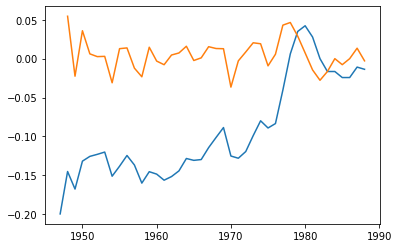

In [10]:
matplotlib.pyplot.plot(HSEINV.year, HSEINV.lprice)
matplotlib.pyplot.plot(HSEINV.year, HSEINV.gprice)

***
## Model a Time Trend

#### Estimate the time trend of log housing investment
$$linvpc = \beta_0 + \beta_1 t + u_t$$

In [11]:
model_est = smf.ols(formula = 'linvpc ~ 1 + t', data = HSEINV).fit()

#### Get the estimation results

In [12]:
print(model_est.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     20.19
Date:                Mon, 22 Nov 2021   Prob (F-statistic):           5.85e-05
Time:                        11:52:08   Log-Likelihood:                 23.290
No. Observations:                  42   AIC:                            -42.58
Df Residuals:                      40   BIC:                            -39.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8331      0.043    -19.297      0.0

#### How would you interpret $\beta_1$?

0.81% growth in housing investment per year, on average from 1947 to 1988

#### At 5% significance level, what would you conclude about $\beta_1$?

Rejet the null hypothesis that there is no growth in housing investment

#### Plot the time series of log housing investment (predicted vs actual)

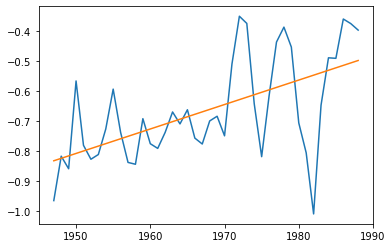

In [13]:
matplotlib.pyplot.plot(HSEINV.year, HSEINV.linvpc)
matplotlib.pyplot.plot(HSEINV.year, model_est.predict())

***
## Estimate a Static Housing Investment Model

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + u_t$$

#### Estimate the model

In [15]:
model_est = smf.ols(formula = 'linvpc ~ 1 + lprice', data = HSEINV).fit()

#### Get the estimation results

In [16]:
print(model_est.summary())

                            OLS Regression Results                            
Dep. Variable:                 linvpc   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     10.53
Date:                Mon, 22 Nov 2021   Prob (F-statistic):            0.00238
Time:                        12:00:53   Log-Likelihood:                 19.617
No. Observations:                  42   AIC:                            -35.23
Df Residuals:                      40   BIC:                            -31.76
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5502      0.043    -12.788      0.0

#### How would you interpret $\beta_1$?

1% increase in house price is associated with 1.2409% increase in housing investment

#### At 5% significance level, what would you conclude about $\beta_1$?

#### Plot the time series of log house price (predicted vs actual)

***
## Estimate a Static Housing Investment Model with Time Trend

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + \beta_2 t + u_t$$

#### Estimate the model

#### Get the estimation results

#### At 5% significance level, what would you conclude about $\beta_1$?

#### Plot the time series of log house price (predicted vs actual)

***
## Estimate a Finite Distributed Lag Model

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + \beta_2 lprice_{t-1} + u_t$$

#### Estimate the model

#### Get the estimation results

#### How would you interpret $\beta_1$?

#### How would you interpret $\beta_2$?

#### Plot the time series of log house price (predicted vs actual)

***
## Estimate a Finite Distributed Lag Model with Time Trend

Consider a housing investment model log-log specification:
$$linvpc_t = \beta_0 + \beta_1 lprice_t + \beta_2 lprice_{t-1} + t + u_t$$

#### Estimate the model

#### Get the estimation results

#### How would you interpret $\beta_1$?

#### How would you interpret $\beta_2$?

#### Plot the time series of log house price (predicted vs actual)

***
## References

- Jeffrey M. Wooldridge (2019). "Introductory Econometrics: A Modern Approach, 7e" Chapter 10.

- The pandas development team (2020). "[pandas-dev/pandas: Pandas](https://pandas.pydata.org/)." Zenodo.

- Seabold, Skipper, and Josef Perktold (2010). "[statsmodels: Econometric and statistical modeling with python](https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html)." Proceedings of the 9th Python in Science Conference.